# Построение моделей

В этой секции мы построим три модели и сравним их производительность.

1. Logistic Regression (sklearn) - baseline.  
Представим историю навигаций в виде текста. C помощью классического метода bag of words(BOW) и кодирования one-hot получим признаки в виде 0 или 1, т.е есть ли слово в тексте или нет. Применим логистическую регрессию для бинарной классфикации.

2. Gradient Boosting (XGBoost).  
Представим историю навигаций в виде текста. C помощью классического метода bag of words(BOW) и кодирования one-hot получим признаки в виде 0 или 1, т.е есть ли слово в тексте или нет. Применим градиентный бустинг над решающими деревьями для бинарной классфикации.

3. Vanilla RNN (PyTorch).  
Представим историю навигаций в виде текста. С помощью словаря преобразуем текст в последовательности чисел, которые отдадим на вход в нейронную сеть, состоящую из RNN-ячеек. Полученные на выходе embeddings классифицируем с помощью сигмоидальной функции активации и некого порога - threshold(decision boundary).


### Метрики качества классификации



Из-за того, что в задаче наблюдается дисбалланс классов, оптимизируемой метрикой качества выбрана F-measure,
$$ F_\beta = (1 + \beta^2) \cdot \frac{precision \cdot recall}{(\beta^2 \cdot precision) + recall},  \beta=1$$

Нам нужно максимизировать и recall и precision для класса бизнес-аккаунтов. $\beta=1$, так как мы не можем отдать предпочтение ни одной из двух этих мер. 

С точки зрения бизнеса, возможно, стоило бы максимизировать только recall, по причине того, что если мы сильнее ошибаемся в precision, то покажем промо обычным пользователям, что не критично. Однако для того, чтобы сказать точно, нужно произвести расчет стоимости ошибок первого и второго рода (False Negative и False Postitive соотвественно). Из таких расчетов можно сделать вывод о весах precision и recall в данной задаче. У нас этих расчетов нет, поэтому оптимизируем гармоническое среднее.

Всегда можно выбрать другой коэффициент $\beta$, если с точки зрения бизнеса это станет необходимо.

### Train и  test

Данные для обучения взяты за первые 9 месяцев 2019 года, разделены на две части в пропорции $1/3$ и $2/3$.  
Стоит сделать важную ремарку о стационарности процесса. На самом деле классифицировать придётся на данных из будущего, и, конечно, тестовую выборку было бы правильно строить на данных из будущего. Но мы воспользуемся знанием о том, что бизнес-страницы сайта не менялись в течении 2019 года. Значит, мы можем расчитывать на стационарность в этом аспекте процесса.  
Модели имеют склонность "протухать" со временем. Поэтому в данном случае лучше предусмотреть регулярное дообучение на новых данных или полное переобучение модели (если это не дорого по ресурсам).


### helpers.py

В файле helpers.py содержатся классы и функции, которые используются в этом ноутбуке. Цель - понизить детализацию кода в ноутбуке и повысить читабельность, оставив по возможности только высокоуровневые вызовы.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import xgboost
from xgboost import to_graphviz

import torch
from torch import nn
import torch.nn.functional as F

import helpers

import warnings
warnings.filterwarnings('ignore')

print(np.__version__)
print(pd.__version__)
print(torch.__version__)
print(xgboost.__version__)

1.17.4
0.25.3
1.5.1
0.90


### Global variables and options

In [2]:
CLASSIFICATION_RESULTS = {}

pd.set_option('precision', 3)

helpers.init_random_seed()

### Load and filter dataset

In [3]:
user_ids, business_labels, navigation_counts, decoded_visits, encoded_visits = helpers.load_dataset()

print('Всего посетителей: ', len(business_labels))
print('Бизнес-аккаунтов создано: ', business_labels.sum())
print('Обычных аккаунтов создано: ', len(list(filter(lambda x: x < 1, business_labels))))

print('\nПример последовательности переходов по URL:', encoded_visits[66])

Всего посетителей:  10116
Бизнес-аккаунтов создано:  1040
Обычных аккаунтов создано:  9076

Пример последовательности переходов по URL: /startpage/ /business/resellers-sign-up/ /startpage/ /ppc/perpetual/lp1/ /in-ppc /in- /in-pc /in-web /in-ppc/ /startpage/ pause /buy/web/offer/plan/ /account/password/create/ /startpage/ /buy/web/offer/plan/ /account/info/products-list/ /online/startpage/ /startpage/ /buy/web/offer/plan/ /startpage/ pause /install/desktop/trial-thank-you/ /buy/in-app/offer/ /account/password/recover/ /account/password/reset/ /account/info/products-list/ /business/buy-online/


Самый короткий clickstream: 2 токенов
Самый длинный clickstream: 143 токенов


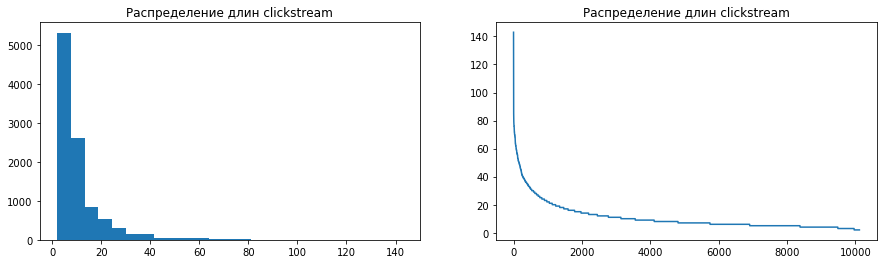

In [4]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(121)
ax.set_title('Распределение длин clickstream')
ax.hist(navigation_counts, bins=25)

ax = fig.add_subplot(122)
ax.set_title('Распределение длин clickstream')
ax.plot(sorted(navigation_counts, reverse=True))

print('Самый короткий clickstream: {0} токенов'.format(min(navigation_counts)))
print('Самый длинный clickstream: {0} токенов'.format(max(navigation_counts)))

##### Tokenizer

In [5]:
tokens = []
tokens = set([visit for visits in encoded_visits for visit in visits.split()])
print('Число уникальных токенов:', len(tokens))

Число уникальных токенов: 836


### One-hot BOW encoder

In [6]:
vectorizer = CountVectorizer(
    binary=True,
    token_pattern="[^ ]+",
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=0.0,
    stop_words=['pause']
)

### Prepare train and test data points (One-hot)

In [7]:
train_data, test_data, train_labels, test_labels = helpers.prepare_train_test_data(vectorizer, encoded_visits, business_labels)
helpers.save_one_hot_test_dataset(test_data, test_labels)

feature_names = vectorizer.get_feature_names()

## Logistic Regression model

In [8]:
lr_model = helpers.fit_predict_logistic_reg(
    train_data,
    test_data,
    train_labels,
    test_labels,
    CLASSIFICATION_RESULTS,
    'BOW One-hot + LR (baseline)'
)
print(lr_model)

helpers.save_model(lr_model, 'lr_model')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished


TRAIN DATASET:
              precision    recall  f1-score   support

           0      0.991     0.995     0.993      6071
           1      0.955     0.926     0.940       706

    accuracy                          0.988      6777
   macro avg      0.973     0.961     0.967      6777
weighted avg      0.988     0.988     0.988      6777

TEST DATASET:
              precision    recall  f1-score   support

           0      0.988     0.994     0.991      3005
           1      0.940     0.892     0.916       334

    accuracy                          0.984      3339
   macro avg      0.964     0.943     0.953      3339
weighted avg      0.983     0.984     0.983      3339

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=4, penalty='l2',
                     random_state=0, refit=True, scoring='f1',
                     solver

## XGBClassifier model

In [9]:
xgb_model = helpers.fit_predict_xgboost(
    train_data,
    test_data,
    train_labels,
    test_labels,
    CLASSIFICATION_RESULTS,
    'BOW One-hot + XGBoost'
)
print(xgb_model)

helpers.save_model(xgb_model, 'xgb_model')

[0]	validation_0-error:0.015274	validation_0-f1_err:0.073806
Multiple eval metrics have been passed: 'validation_0-f1_err' will be used for early stopping.

Will train until validation_0-f1_err hasn't improved in 20 rounds.
[1]	validation_0-error:0.015274	validation_0-f1_err:0.073806
[2]	validation_0-error:0.013477	validation_0-f1_err:0.065312
[3]	validation_0-error:0.013777	validation_0-f1_err:0.067055
[4]	validation_0-error:0.014675	validation_0-f1_err:0.071118
[5]	validation_0-error:0.014376	validation_0-f1_err:0.069364
[6]	validation_0-error:0.014675	validation_0-f1_err:0.071118
[7]	validation_0-error:0.013777	validation_0-f1_err:0.06686
[8]	validation_0-error:0.013777	validation_0-f1_err:0.06686
[9]	validation_0-error:0.013477	validation_0-f1_err:0.065312
[10]	validation_0-error:0.013777	validation_0-f1_err:0.06686
[11]	validation_0-error:0.013777	validation_0-f1_err:0.066667
[12]	validation_0-error:0.013777	validation_0-f1_err:0.066667
[13]	validation_0-error:0.013477	validation_

### Features Importance

In [10]:
helpers.show_importance_scores(xgb_model.feature_importances_, feature_names, topn=15)

,Index,Adjusted URL,Importance Score
10,22,/business/buy-online/,0.455
20,35,/business/startpage/,0.094
12,27,/business/download/desktop/,0.086
16,31,/business/resellers-sign-up/,0.018
15,30,/business/products/trial-thank-you/,0.015
18,33,/business/resources/,0.015
3,8,/account/info/products-list/,0.014
14,29,/business/pro-features/,0.014
2,7,/account/info/payment/,0.010
29,97,/esign/confirm/email-send,0.010


In [11]:
# to_graphviz(xgb_model, num_trees=0)

## RNN model

### Create Vocabulary

In [12]:
token_to_id = {token: i + 1 for i, token in enumerate(tokens)}
token_to_id['pad_token'] = 0

MAX_LENGTH = max(map(len, [visit.split() for visit in encoded_visits]))

In [13]:
train_data_nn, test_data_nn, train_labels_nn, test_labels_nn = train_test_split(encoded_visits, business_labels,
                                                                        test_size=0.33, random_state=0)

In [14]:
train_dataset_nn = helpers.VisitorsDataset(train_data_nn, train_labels_nn, token_to_id, MAX_LENGTH, 'pad_token')
test_dataset_nn = helpers.VisitorsDataset(test_data_nn, test_labels_nn, token_to_id, MAX_LENGTH, 'pad_token')

helpers.save_rnn_test_dataset(test_dataset_nn)

print('Пример последовательности переходов по URL:\n')
print(train_data_nn[314])
print('\nПример последовательности переходов по URL, закодированный индексами в словаре + padding:\n')
print(train_dataset_nn[314])

Пример последовательности переходов по URL:

/ppc/web/en/competitors/perpetual/join/ /business/startpage/ /business/pro-features/ /business/startpage/ /join/new-pdf-features/ /business/startpage/

Пример последовательности переходов по URL, закодированный индексами в словаре + padding:

(tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         

In [15]:
rnn_model = helpers.RNNLoop(len(tokens) + 1)
batch_size = 128
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

(best_val_score, best_val_loss, best_rnn_model) = helpers.train_eval_loop(rnn_model,
                                        train_dataset_nn,
                                        test_dataset_nn,
#                                         nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([9]).to(device)),
                                        nn.BCEWithLogitsLoss(),
                                        scorer=helpers.f1_scorer,
                                        device=device,
                                        batch_size=batch_size,
                                        epoch_n=1000,
                                        early_stopping_patience=5
                                        )

print()
print('Лучшая оценка функции потерь на валидации:', best_val_loss)
print('Лучшая оценка качества на валидации:', best_val_score)
print()
print('Лучшая модель на валидации:', best_rnn_model)

helpers.save_model(best_rnn_model,  'rnn_model')

Эпоха 0
Эпоха: 53 итераций, 0.99 сек
Суммарное значение функции потерь на обучении 32.92782247066498
f1_scorer оценка на обучении 0.15960912052117265
Суммарное значение функции потерь на валидации 15.08437329530716
f1_scorer оценка на валидации 0.17204301075268819
Новая лучшая модель!

Эпоха 1
Эпоха: 53 итераций, 0.70 сек
Суммарное значение функции потерь на обучении 27.17060798406601
f1_scorer оценка на обучении 0.19876543209876546
Суммарное значение функции потерь на валидации 12.759152472019196
f1_scorer оценка на валидации 0.20512820512820515
Новая лучшая модель!

Эпоха 2
Эпоха: 53 итераций, 0.71 сек
Суммарное значение функции потерь на обучении 23.3502214550972
f1_scorer оценка на обучении 0.21728786677240286
Суммарное значение функции потерь на валидации 11.11307767033577
f1_scorer оценка на валидации 0.25190839694656486
Новая лучшая модель!

Эпоха 3
Эпоха: 53 итераций, 0.71 сек
Суммарное значение функции потерь на обучении 20.556572794914246
f1_scorer оценка на обучении 0.326188

Эпоха: 53 итераций, 0.72 сек
Суммарное значение функции потерь на обучении 2.569516426883638
f1_scorer оценка на обучении 0.9434229137199434
Суммарное значение функции потерь на валидации 1.5918890684843063
f1_scorer оценка на валидации 0.9217134416543575

Эпоха 30
Эпоха: 53 итераций, 0.71 сек
Суммарное значение функции потерь на обучении 2.561337724328041
f1_scorer оценка на обучении 0.9444053483462349
Суммарное значение функции потерь на валидации 1.569139352068305
f1_scorer оценка на валидации 0.9217134416543575

Эпоха 31
Эпоха: 53 итераций, 0.71 сек
Суммарное значение функции потерь на обучении 2.4393546832725406
f1_scorer оценка на обучении 0.9456598447424135
Суммарное значение функции потерь на валидации 1.5064533976837993
f1_scorer оценка на валидации 0.932748538011696
Новая лучшая модель!

Эпоха 32
Эпоха: 53 итераций, 0.73 сек
Суммарное значение функции потерь на обучении 2.3627219991758466
f1_scorer оценка на обучении 0.9476661951909476
Суммарное значение функции потерь на вал

In [16]:
algo_name = 'Embeddings + RNN(E-{0} R-{1} B-{2})'.format(
    best_rnn_model.rnn.input_size,
    best_rnn_model.rnn.hidden_size,
    batch_size
)

helpers.rnn_predict_and_store_results(best_rnn_model, train_dataset_nn, test_dataset_nn, device,
                                      CLASSIFICATION_RESULTS, algo_name)

TRAIN DATASET:
              precision    recall  f1-score   support

           0      0.995     0.993     0.994      6071
           1      0.943     0.955     0.949       706

    accuracy                          0.989      6777
   macro avg      0.969     0.974     0.971      6777
weighted avg      0.989     0.989     0.989      6777

TEST DATASET:
              precision    recall  f1-score   support

           0      0.995     0.990     0.992      3005
           1      0.911     0.955     0.933       334

    accuracy                          0.986      3339
   macro avg      0.953     0.972     0.963      3339
weighted avg      0.987     0.986     0.986      3339



### Score

In [17]:
bus_class_scores_df = helpers.serialize_models_scores(CLASSIFICATION_RESULTS)
bus_class_scores_df = bus_class_scores_df.sort_values(by=['F1 test', 'F1 train'], ascending=False)
bus_class_scores_df[['Classifier', 'F1 test', 'F1 train']]

,Classifier,F1 test,F1 train
1,BOW One-hot + XGBoost,0.944,0.956
2,Embeddings + RNN(E-256 R-32 B-128),0.933,0.949
0,BOW One-hot + LR (baseline),0.916,0.940
